### Submmited by Shai Gabay-Angel (ID 305413130) & Dani Magner (ID 304216807)
________________________________________________________________________________

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-proccessing

<span style="color:blue"> In the following section we will read the Titanic data file and create additional columns to the dataframe, which are required for the graphic analysis.

In [142]:
df= pd.read_csv('./titanic.csv') 

df['died']=1.-df['survived']
df['cabin_area'] = df['cabin'].str[0] 
df['boat_num'] = df['boat'].astype('str')
df['cabin_num'] = pd.to_numeric(df['cabin'].str.split(' ').str[0].str[1:])

df.head(3) #Quick overview of the headers of the modified datframe

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,died,cabin_area,boat_num,cabin_num
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0.0,B,2,5.0
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0.0,C,11,22.0
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",1.0,C,nan,22.0


# Data Exploration

<span style="color:blue"> Our goal in this section is to explore the effects of different parameters on the survival of the Titanic passengers.
For *categorial parameters*, such as sex and age, we will use "bars" graphs.
For *numerical parameters*, such as fare, we will plot histograms.
According to our findings, we will choose and optimize a classification algorithm to predict who will survive.

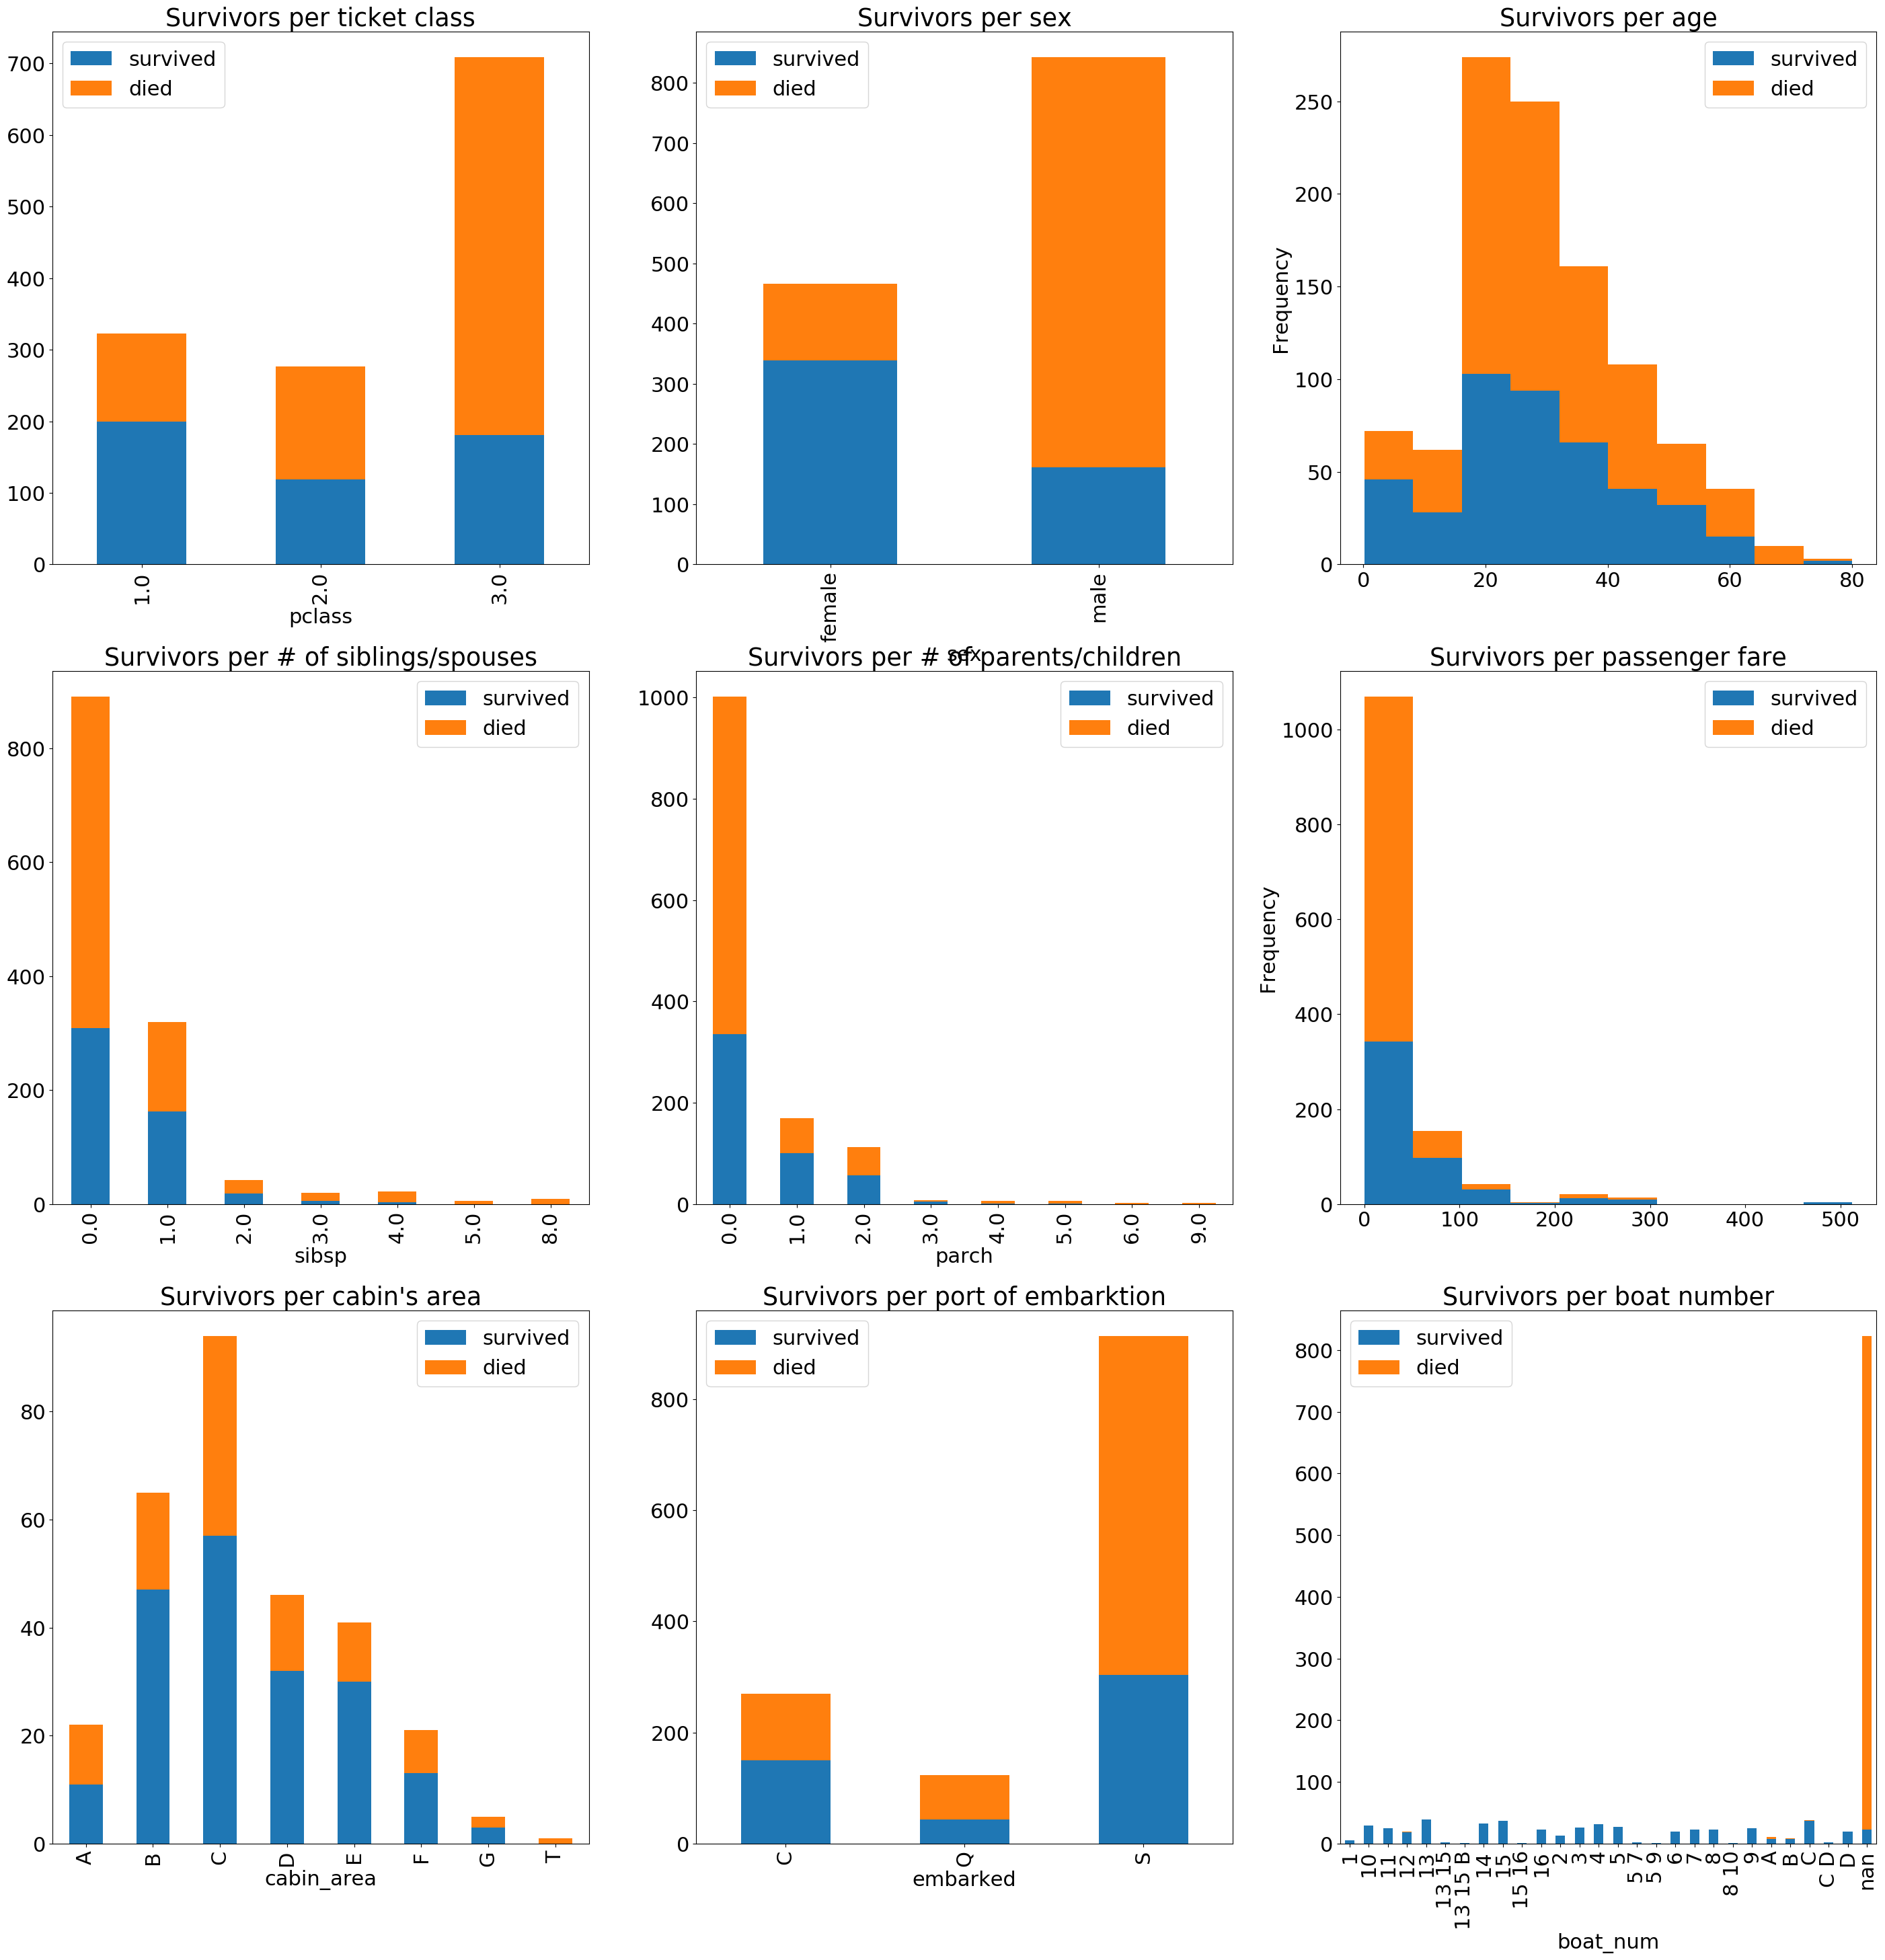

In [143]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(35, 35))

def plot_catagorical(df,field,title,axes):
    # plots a "bars" plot for a field in data frame
    df = df[['survived','died',field]].groupby([field]).sum()
    df.reset_index(inplace=True)
    df.plot(kind='bar',x=field,y=['survived','died'],stacked =True,title=title,ax=axes)

def plot_hist(data,field,title,axes):
    df= pd.DataFrame({'survived': data.groupby('survived').get_group(1)[field],
              'died':   data.groupby('survived').get_group(0)[field]})
    df.plot.hist(y=['survived','died'],stacked=True,title=title,ax=axes)
        
# plot multiple sets
plot_catagorical(df,'pclass','Survivors per ticket class',axes[0,0])
plot_catagorical(df,'sex','Survivors per sex',axes[0,1])
plot_hist(df,'age','Survivors per age',axes[0,2])
plot_catagorical(df,'sibsp','Survivors per # of siblings/spouses',axes[1,0])
plot_catagorical(df,'parch','Survivors per # of parents/children',axes[1,1])
plot_hist(df,'fare','Survivors per passenger fare',axes[1,2])
plot_catagorical(df,'cabin_area','Survivors per cabin\'s area',axes[2,0])
plot_catagorical(df,'embarked','Survivors per port of embarktion',axes[2,1])

# We recieved an extra data field in the csv file - boat. We plotted the survival rate as function of this parameter and
# we figured out that it was probably supposed to be left out :)

plot_catagorical(df,'boat_num','Survivors per boat number',axes[2,2])


plt.show()

# Statistical Analysis
<span style="color:blue"> In this section we will show some statistical calculations following the graphical analysis.

In [144]:
print('overall survival rate:', 100*df['survived'].sum()/df['survived'].count())

def statistics_numerical(data,field):
    print ('\n',field,'\n', data.groupby('survived').describe()[field], '\n')

statistics_numerical(df,'age')
statistics_numerical(df,'fare')

def statistics_categorial(df,field):
    df2 =df[['survived','died',field]].groupby([field]).sum()
    df2['total']=df2['survived']+df2['died']
    df2['survival rate']=(df2['survived']/df2['total'])*100
    del df2['survived']
    del df2['died']
    print ('\n',field,'\n', df2,'\n')

statistics_categorial(df,'sex')
statistics_categorial(df,'pclass')
statistics_categorial(df,'sibsp')
statistics_categorial(df,'parch')
statistics_categorial(df,'cabin_area')
statistics_categorial(df,'embarked')


overall survival rate: 38.1970970206

 age 
           count       mean        std     min   25%   50%   75%   max
survived                                                             
0.0       619.0  30.545369  13.922539  0.3333  21.0  28.0  39.0  74.0
1.0       427.0  28.918228  15.061481  0.1667  20.0  28.0  38.0  80.0 


 fare 
           count       mean        std  min      25%   50%    75%       max
survived                                                                  
0.0       808.0  23.353831  34.145096  0.0   7.8542  10.5  26.00  263.0000
1.0       500.0  49.361184  68.648795  0.0  11.2146  26.0  57.75  512.3292 


 sex 
         total  survival rate
sex                         
female  466.0      72.746781
male    843.0      19.098458 


 pclass 
         total  survival rate
pclass                      
1.0     323.0      61.919505
2.0     277.0      42.960289
3.0     709.0      25.528914 


 sibsp 
        total  survival rate
sibsp                      
0.0    891.0

## Conclusions

* The fraction of survivors which purchased class 1 tickets was higher in comparison with classes 2 and 3. This insight is also supported by the graph of survivors per passenger fare.
* In terms of sex - women are more likely to survive the tragedy (72.7% Vs. 19.1%).
* The Survival per age graph does not provide a clear trend. This parameter will probably be less significant in the prediction model.
* The survival rates of passengers with sibsp of above 3.0 and or parch above 4.0 (=> big families) are significantly lower.
* It seems that the cabin area and port of embarktion also had impact on whether the passenger survived or not.

The graph of survival per boat was found to be very conclusive. It seems that if the passenger was able to get on any boat it was almost certain that he would survive. We will drop this column while buiding our classification model.


# Classification Algorithm

<span style="color:blue"> In this section we will try the different classification algorithms studied in class (K-Nearest neighbors,SVM) in order to find the best prediction model for surviving the vacation on the Titanic.
The first step will be to create random training and testing sets. Prior to the data split we will need to pre-process some features in the data in order to deal with missing values. We will also explore ome feature engineering in order to reach the best classification score.

In [145]:
from sklearn import svm
from sklearn import neighbors 
from sklearn.model_selection import train_test_split

In [241]:
# Choosing the features (from the original ones) that shall be included in the dataframe input of our models

X= df[['pclass','sex','age','sibsp','parch','fare','embarked','cabin_area','cabin_num']].copy()

# Pre-processing the data to numerical representation

# Gender:
X['sex'].replace('male',1.0,inplace=True)
X['sex'].replace('female',0.0,inplace=True)

#Port and cabin's area
X= pd.get_dummies(X,columns=['embarked','cabin_area'],drop_first=False) #OneHot encoding for strings
X.replace(1,1.0,inplace=True)
X.replace(0,0.0,inplace=True)

# Some feature engineering we tried out (we kept only those who contributed to the model's score):

X['lone_kid']=np.where((X['age']<18) & (X['parch']==0),1.0,0.0)
#X['adults_lowclass']=np.where( (X['age'].between(18,60)) & (X['pclass']>=2),1.0,0.0)
#X['lone_elderly']=np.where((X['age']>60) & ((X['parch']==0)&(X['sibsp']==0)),1.0,0.0)
#X['infant']=np.where((X['age']<5),1.0,0.0)
#X['child']=np.where((X['age'].between(5,13)),1.0,0.0)
#X['teen']=np.where((X['age'].between(13,18)),1.0,0.0)
#X['Family_size']=np.where(((X['sibsp']+X['parch']+1)>4),1.0,0.0)


# Figuring out where we have NaN cells that we need to handle
print (X.isnull().sum())

pclass             1
sex                1
age              264
sibsp              1
parch              1
fare               2
cabin_num       1028
embarked_C         0
embarked_Q         0
embarked_S         0
cabin_area_A       0
cabin_area_B       0
cabin_area_C       0
cabin_area_D       0
cabin_area_E       0
cabin_area_F       0
cabin_area_G       0
cabin_area_T       0
lone_kid           0
dtype: int64


<span style="color:blue"> As shown in the previous output, there are very few cells of pclass/sex/sibsp/parch/fare with missing data. In this case, we could definitely neglect them as they will probably have no effect on the model's prediction. However, in terms of the 'age' feature, there are 264 missing values and 77% of the cabin numbers are missing.

<span style="color:blue">We decided to replace all the NaN values with the meadian value in all cases. We know that the reliability of such modification in the cabin_num fieldis low but it was discovered that it improves our classification algorithm.

In [242]:
y= df['survived'].copy()

y = np.where(y==1.0, True, False)

# Creating training and testing sets - 80% : 20%

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.20)

X_test=X_test.fillna(X_train.median())
X_train=X_train.fillna(X_train.median())

In [243]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

### K-Neighbors

In [244]:
# Trying out the knn model with different K Neighbors

score = []

for i in range (1,15):
    knn = neighbors.KNeighborsClassifier(i) 
    knn.fit(X_train, y_train)
    score += [knn.score(X_test,y_test)]
    
print('The best prediction score we obtained with this model is with a K value of',np.argmax(np.array(score)),'.\nmax score:', np.max(np.array(score)))


The best prediction score we obtained with this model is with a K value of 4 .
max score: 0.797709923664


### Support vector machines (SVMs)

#### 1. Linear

In [245]:
svc_1 = svm.SVC(kernel='linear')
svc_1.fit(X_train, y_train)
score=svc_1.score(X_test, y_test)
  
print ('The prediction score we obtained with this model is',score)

The prediction score we obtained with this model is 0.793893129771


#### 2. Poly

In [246]:
C =[0.1,1.,10.,100.,1000.]
gamma = [5,0.5,0.05,0.005,0.0005,0.00005,0.00005]

import itertools

score = []
coeff = []

for (i,j) in itertools.product(C,gamma):
    for p in range (2,6):
        svc_2 = svm.SVC(kernel='poly', degree=p) # polynomial kernel
        svc_2.fit(X_train, y_train)
        score +=[svc_2.score(X_test, y_test)]
        coeff += [(p,i,j)]
        
print ('The best prediction score we obtained with this model is',np.max(np.array(score)),'.\nthe (degree, C, gamma) are',coeff[np.argmax(np.array(score))])


The best prediction score we obtained with this model is 0.801526717557 .
the (degree, C, gamma) are (2, 0.1, 5)


#### 3. RBF

In [247]:
C =[0.1,1.,10.,100.,1000.,10000.]
gamma = [5,0.5,0.05,0.005,0.0005,0.00005,0.00005]

import itertools

score = []
coeff = []

for (i,j) in itertools.product(C,gamma):
    svc_3 = svm.SVC(kernel='rbf', C=i, gamma=j) # RBF kernel (Radial Basis Function)
    svc_3.fit(X_train, y_train)
    score +=[svc_3.score(X_test, y_test)]
    coeff += [(i,j)]

print ('The best prediction score we obtained with this model is',np.max(np.array(score)),'.\nthe coefficients C, gamma are',coeff[np.argmax(np.array(score))])


The best prediction score we obtained with this model is 0.835877862595 .
the coefficients C, gamma are (1.0, 5)


In [248]:
# Analysing our False-Negative and False-Positive outcomes of the best model 
from sklearn.metrics import confusion_matrix

y_pred = svc_3.predict(X_test)
print(confusion_matrix(y_test,y_pred))


[[145  18]
 [ 36  63]]
